# **Load the dataset**


Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
df = pd.read_csv('drive/MyDrive/Project_data/ecommerce_customer_data_custom_ratios.csv')

Initial Dataset Overview

In [ ]:
print(df.head())
print("Dataset Shape:", df.shape)
print(df.describe())
print("\nDataset Info:\n")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        46251  2020-09-08 09:38:32      Electronics             12         3   
1        46251  2022-03-05 12:56:35             Home            468         4   
2        46251  2022-05-23 18:18:01             Home            288         2   
3        46251  2020-11-12 13:13:29         Clothing            196         1   
4        13593  2020-11-27 17:55:11             Home            449         1   

   Total Purchase Amount Payment Method  Customer Age  Returns  \
0                    740    Credit Card            37      0.0   
1                   2739         PayPal            37      0.0   
2                   3196         PayPal            37      0.0   
3                   3509         PayPal            37      0.0   
4                   3452    Credit Card            49      0.0   

         Customer Name  Age  Gender  Churn  
0  Christine Hernandez   37    Male      0  
1  Christine Hernandez   3

# **EDA**

     -Churn Distribution

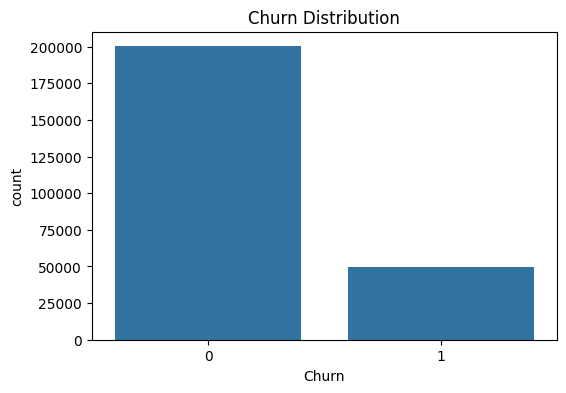

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

  -Numerical Feature Distributions

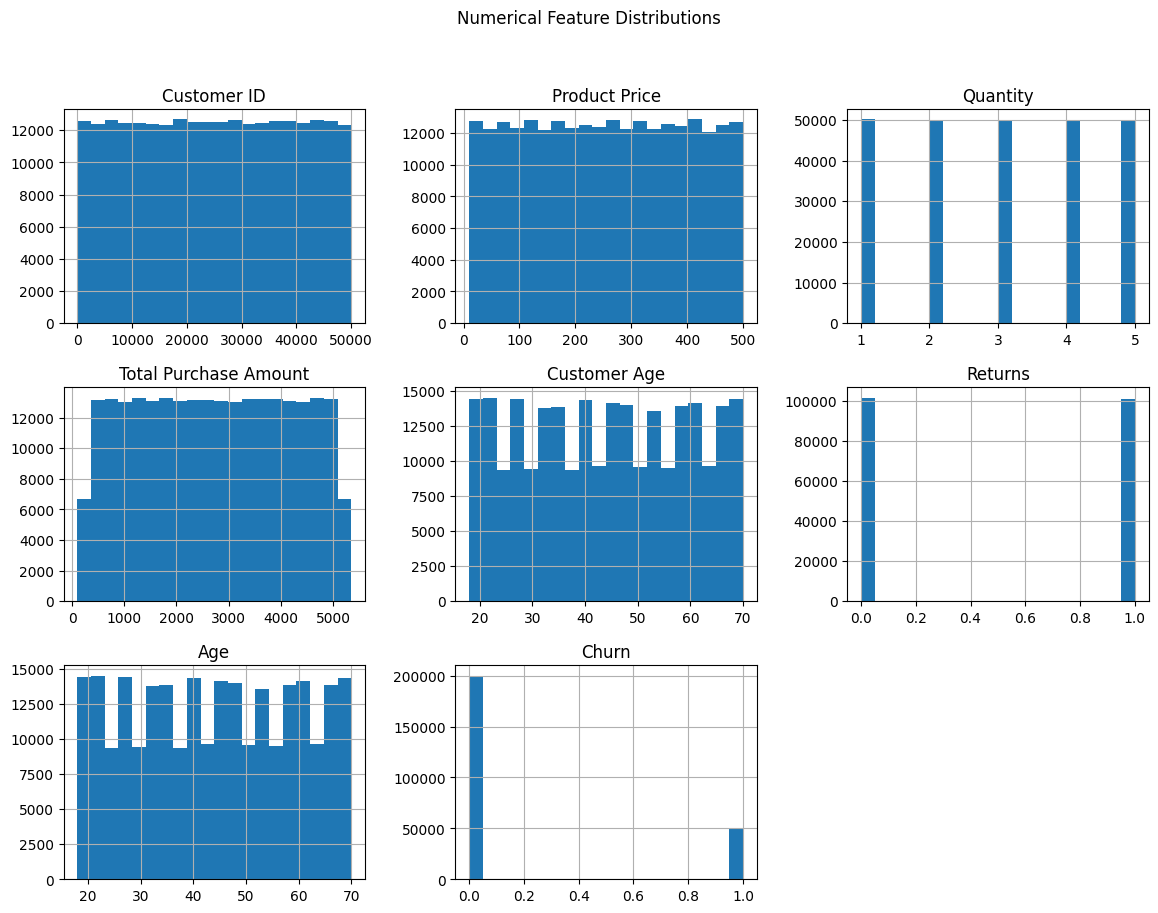

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_columns].hist(bins=20, figsize=(14, 10))
plt.suptitle("Numerical Feature Distributions")
plt.show()

   -categorical Feature Distributions

In [ ]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")

Purchase Date: 249736 unique values
Product Category: 4 unique values
Payment Method: 4 unique values
Customer Name: 39920 unique values
Gender: 2 unique values


# **FEATURE ENGINEERING**

In [ ]:
# Feature Engineering

# 1. Total Spend
# Summing up all purchase amounts for each customer
df['total_spend'] = df.groupby('Customer ID')['Total Purchase Amount'].transform('sum')

# 2. Frequency of Purchase
# Counting the number of purchases for each customer
df['purchase_frequency'] = df.groupby('Customer ID')['Purchase Date'].transform('count')

# 3. Time Since Last Purchase
# Convert 'purchase_date' to datetime if not already in datetime format
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# Sort by 'Customer ID' and 'Purchase Date'
df = df.sort_values(by=['Customer ID', 'Purchase Date'])

# Calculate the time difference between consecutive purchases
df['time_diff'] = df.groupby('Customer ID')['Purchase Date'].diff().dt.days

# Calculate the average time between purchases for each customer
df['days_since_last_purchase'] = df.groupby('Customer ID')['time_diff'].transform('mean')

# 4. Extract Time Features
# Extract day of the week, hour, and month from 'Purchase Date'
df['purchase_day'] = df['Purchase Date'].dt.day_name()  # Day of the week (e.g., Monday)
df['purchase_hour'] = df['Purchase Date'].dt.hour       # Hour of the day (0-23)
df['purchase_month'] = df['Purchase Date'].dt.month     # Month (1-12)

# 5. Encode Gender
# Map 'Gender' to numeric values (0 for Male, 1 for Female)
df['gender_encoded'] = df['Gender'].map({'Male': 0, 'Female': 1})

# 6. Drop Irrelevant Columns
# Note: Not droping ID as it will used as an index for clustering or analysis later
df = df.drop(columns=['Customer Name'])
df = df.drop(columns=['Customer Age'])
# Display the updated dataset
df.head()


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,total_spend,purchase_frequency,time_diff,days_since_last_purchase,purchase_day,purchase_hour,purchase_month,gender_encoded
151166,1,2023-07-19 19:09:20,Books,169,5,3491,PayPal,1.0,70,Male,0,3491,1,NaN,NaN,Wednesday,19,7,0
244416,2,2021-03-05 14:30:42,Books,144,1,4210,PayPal,1.0,27,Female,0,7988,3,NaN,312.500000,Friday,14,3,1
244417,2,2021-09-19 16:55:21,Books,98,4,959,PayPal,NaN,27,Female,0,7988,3,198.0,312.500000,Sunday,16,9,1
244418,2,2022-11-21 06:48:05,Electronics,178,3,2819,PayPal,0.0,27,Female,0,7988,3,427.0,312.500000,Monday,6,11,1
231817,3,2020-09-27 22:26:24,Electronics,402,2,445,Credit Card,0.0,23,Female,0,22587,8,NaN,141.285714,Sunday,22,9,1


In [ ]:
print("Dataset Shape:", df.shape)
print(df.describe())
print("\nDataset Info:\n")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (250000, 19)
        Customer ID                  Purchase Date  Product Price  \
count  250000.00000                         250000  250000.000000   
mean    25004.03624  2021-11-06 23:31:24.372304128     254.659512   
min         1.00000            2020-01-01 00:15:00      10.000000   
25%     12497.75000  2020-12-02 19:33:23.249999872     132.000000   
50%     25018.00000            2021-11-06 13:10:59     255.000000   
75%     37506.00000  2022-10-11 03:42:32.750000128     377.000000   
max     50000.00000            2023-09-15 12:24:08     500.000000   
std     14428.27959                            NaN     141.568577   

            Quantity  Total Purchase Amount        Returns            Age  \
count  250000.000000          250000.000000  202404.000000  250000.000000   
mean        2.998896            2725.370732       0.497861      43.940528   
min         1.000000             100.000000       0.000000      18.000000   
25%         2.000000            1477.00000

**Convert Object Data to Numerical**

In [ ]:
import pandas as pd

# Assuming `df` is your dataset
categorical_columns = ['Gender', 'Payment Method', 'Product Category']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Verify the changes
print(df.head())


        Customer ID       Purchase Date  Product Price  Quantity  \
151166            1 2023-07-19 19:09:20            169         5   
244416            2 2021-03-05 14:30:42            144         1   
244417            2 2021-09-19 16:55:21             98         4   
244418            2 2022-11-21 06:48:05            178         3   
231817            3 2020-09-27 22:26:24            402         2   

        Total Purchase Amount  Returns  Age  Churn  total_spend  \
151166                   3491      1.0   70      0         3491   
244416                   4210      1.0   27      0         7988   
244417                    959      NaN   27      0         7988   
244418                   2819      0.0   27      0         7988   
231817                    445      0.0   23      0        22587   

        purchase_frequency  ...  purchase_hour  purchase_month gender_encoded  \
151166                   1  ...             19               7              0   
244416                   3

In [ ]:
df.head()

,Customer ID,Purchase Date,Product Price,Quantity,Total Purchase Amount,Returns,Age,Churn,total_spend,purchase_frequency,...,purchase_hour,purchase_month,gender_encoded,Gender_Male,Payment Method_Credit Card,Payment Method_Crypto,Payment Method_PayPal,Product Category_Clothing,Product Category_Electronics,Product Category_Home
151166,1,2023-07-19 19:09:20,169,5,3491,1.0,70,0,3491,1,...,19,7,0,True,False,False,True,False,False,False
244416,2,2021-03-05 14:30:42,144,1,4210,1.0,27,0,7988,3,...,14,3,1,False,False,False,True,False,False,False
244417,2,2021-09-19 16:55:21,98,4,959,NaN,27,0,7988,3,...,16,9,1,False,False,False,True,False,False,False
244418,2,2022-11-21 06:48:05,178,3,2819,0.0,27,0,7988,3,...,6,11,1,False,False,False,True,False,True,False
231817,3,2020-09-27 22:26:24,402,2,445,0.0,23,0,22587,8,...,22,9,1,False,True,False,False,False,True,False


**Handle Missing Values**

In [ ]:
# Handle missing values in 'Returns'
df['Returns'] = df['Returns'].fillna(0)

# Handle missing values in 'time_diff'
df['time_diff'] = df['time_diff'].fillna(-1)

# Handle missing values in 'days_since_last_purchase'
max_days = df['days_since_last_purchase'].max()  # Use max value as replacement
df['days_since_last_purchase'] = df['days_since_last_purchase'].fillna(max_days)


In [ ]:
# Select numerical columns including uint8 (which is used for one-hot encoded columns)
numerical_columns = df.select_dtypes(include=['int64', 'float64', 'uint8']).columns

# Inspect these columns to decide if they need scaling
print("Numerical columns to consider for scaling:", numerical_columns)


Numerical columns to consider for scaling: Index(['Customer ID', 'Product Price', 'Quantity', 'Total Purchase Amount',
       'Returns', 'Age', 'Churn', 'total_spend', 'purchase_frequency',
       'time_diff', 'days_since_last_purchase', 'gender_encoded'],
      dtype='object')


**Return Rate**

In [ ]:

if 'Customer ID' in df.columns and 'Returns' in df.columns:
    # Calculate total returns for each customer
    total_returns = df.groupby('Customer ID')['Returns'].sum()

    # Calculate total purchases for each customer
    total_purchases = df.groupby('Customer ID')['Customer ID'].count()

    # Calculate return rate
    return_rate = total_returns / total_purchases

    # Merge return rate back to the main DataFrame
    df = df.merge(return_rate.rename('return_rate'), on='Customer ID', how='left')

    # Replace NaN values with 0 (e.g., customers with no purchases or returns)
    df['return_rate'].fillna(0, inplace=True)

# Display first few rows to verify
print(df[['Customer ID', 'Returns', 'return_rate']].head())


   Customer ID  Returns  return_rate
0            1      1.0     1.000000
1            2      1.0     0.333333
2            2      0.0     0.333333
3            2      0.0     0.333333
4            3      0.0     0.375000


<ipython-input-13-c19bc602c878>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['return_rate'].fillna(0, inplace=True)


# **Scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Columns to scale
numerical_columns_to_scale = ['total_spend', 'purchase_frequency', 'time_diff', 'days_since_last_purchase', 'Age', 'return_rate' ]

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling
df[numerical_columns_to_scale] = scaler.fit_transform(df[numerical_columns_to_scale])

# Verify the scaling
df[numerical_columns_to_scale].describe()

,total_spend,purchase_frequency,time_diff,days_since_last_purchase,Age,return_rate
count,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05
mean,-7.787548e-18,-1.036256e-16,2.922462e-17,5.172751e-17,-3.296918e-17,4.189360e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.303984e+00,-2.238598e+00,-8.656123e-01,-1.499027e+00,-1.689913e+00,-1.845764e+00
25%,-7.232060e-01,-8.954908e-01,-7.871982e-01,-5.172978e-01,-8.430193e-01,-7.009648e-01
50%,-9.509337e-02,-8.595886e-05,-3.323961e-01,-2.362045e-01,3.874343e-03,-1.408560e-02
75%,6.286262e-01,4.476164e-01,4.256073e-01,1.971140e-01,8.507680e-01,4.438339e-01
max,5.530259e+00,4.924640e+00,6.108019e+00,7.535008e+00,1.697662e+00,2.733431e+00


# **CLUSTERING**

In [ ]:

# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt
# import seaborn as sns


In [ ]:
# # Select relevant features for clustering
# features_for_clustering = ['Age', 'purchase_frequency', 'total_spend',
#                            'time_diff', 'return_rate','days_since_last_purchase']
# X = df[features_for_clustering]


In [ ]:
# # Use the Elbow Method to find the optimal number of clusters
# inertia = []
# k_range = range(1, 11)  # Test k from 1 to 10

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     inertia.append(kmeans.inertia_)

# # Plot the Elbow Curve
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, inertia, marker='o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k')
# plt.show()


In [ ]:
# Compute silhouette scores for each k (from 2 to 10)
#silhouette_scores = []

#for k in range(2, 11):
    #kmeans = KMeans(n_clusters=k, random_state=42)
    #labels = kmeans.fit_predict(X)
    #silhouette_scores.append(silhouette_score(X, labels))

# Plot silhouette scores
#plt.figure(figsize=(8, 5))
#plt.plot(range(2, 11), silhouette_scores, marker='o')
#plt.xlabel('Number of Clusters (k)')
#plt.ylabel('Silhouette Score')
#plt.title('Silhouette Scores for k')
#plt.show()


In [ ]:
# from sklearn.cluster import KMeans

# # Fit the KMeans model
# kmeans = KMeans(n_clusters=5, random_state=42)
# df['cluster'] = kmeans.fit_predict(df[features_for_clustering])

# # Analyze cluster characteristics
# cluster_summary = df.groupby('cluster').mean()
# print(cluster_summary)

# # Save the clustering output
# df.to_csv('ecommerce_clustered_data.csv', index=False)


In [ ]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Perform PCA to reduce dimensions to 2
# pca = PCA(n_components=2)
# df_pca = pca.fit_transform(df[features_for_clustering])

# # Assign the cluster labels
# df_clustered = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
# df_clustered['Cluster'] = kmeans.labels_

# # Plot the clusters
# plt.figure(figsize=(10, 6))
# for cluster in range(5):  # Change 5 to the number of clusters
#     cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
#     plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

# plt.title('Clusters Visualization in 2D Space')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.legend()
# plt.show()


In [ ]:
# # Get the cluster centers
# cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Unscale the centers

# # Create a DataFrame for the centers
# # Use the correct columns (features used for clustering)
# cluster_centers_df = pd.DataFrame(cluster_centers, columns=features_for_clustering)

# print("Cluster Centers:")
# print(cluster_centers_df)

In [ ]:
# # Bar chart for cluster distribution
# cluster_counts = pd.Series(kmeans.labels_).value_counts()

# plt.figure(figsize=(8, 5))
# cluster_counts.sort_index().plot(kind='bar', color='skyblue')
# plt.title('Number of Points in Each Cluster')
# plt.xlabel('Cluster')
# plt.ylabel('Count')
# plt.xticks(range(len(cluster_counts)), [f'Cluster {i}' for i in range(len(cluster_counts))], rotation=0)
# plt.show()


# **Model building**

In [ ]:
# from sklearn.cluster import KMeans

# # Example of fitting KMeans to the data (use your feature set here)
# kmeans = KMeans(n_clusters=5, random_state=42)
# # Fit on the entire DataFrame's features
# cluster_labels = kmeans.fit_predict(df[['Age', 'purchase_frequency', 'total_spend', 'time_diff', 'return_rate', 'days_since_last_purchase']])

# # Check the cluster labels
# print(cluster_labels[:10])  # Print first 10 labels to verify

# # Assign the cluster labels to the DataFrame
# df['cluster_label'] = cluster_labels

# # Check if the 'cluster_label' column is added correctly
# print(df.head())  # Check the first few rows of the DataFrame

In [ ]:
# # Assuming 'cluster_labels' is a numpy array or a pandas Series
# df['cluster_label'] = cluster_labels

# # Check if the 'cluster_label' column is added correctly
# print(X.head())  # Check the first few rows of the DataFrame


In [ ]:
# print(len(df))  # Length of the feature set
# print(len(cluster_labels))  # Length of the cluster labels


In [ ]:
# List of original columns (excluding the original categorical columns)
selected_columns = ['Age', 'purchase_frequency', 'total_spend', 'time_diff', 'return_rate',
                    'days_since_last_purchase', ]

# Get the one-hot encoded columns created from 'Product Category' and 'Payment Method'
encoded_columns = [col for col in df.columns if col.startswith('Payment Method') or col.startswith('Product Category') or col.startswith('Gender')]

# Final feature set (combining selected columns and encoded columns)
X = df[selected_columns + encoded_columns]

# Define the target variable
y = df['Churn']

# Verify the selected features
print("Features (X):", X.columns)
print("Target (y):", y.name)


Features (X): Index(['Age', 'purchase_frequency', 'total_spend', 'time_diff', 'return_rate',
       'days_since_last_purchase', 'Gender_Male', 'Payment Method_Credit Card',
       'Payment Method_Crypto', 'Payment Method_PayPal',
       'Product Category_Clothing', 'Product Category_Electronics',
       'Product Category_Home'],
      dtype='object')
Target (y): Churn


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the split data
print(f"Training set features: {X_train.shape}")
print(f"Test set features: {X_test.shape}")
print(f"Training set target: {y_train.shape}")
print(f"Test set target: {y_test.shape}")


Training set features: (200000, 13)
Test set features: (50000, 13)
Training set target: (200000,)
Test set target: (50000,)


In [ ]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Define the models with their best hyperparameters
rf = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42,
    class_weight='balanced'  # Handling data imbalance with class weights
)

xgb_model = xgb.XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.1,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    scale_pos_weight=4  # You can also adjust scale_pos_weight if imbalance is severe
)

logreg = LogisticRegression(
    C=0.01,
    penalty='l1',
    solver='liblinear',
    random_state=42,
    class_weight='balanced'  # Handling data imbalance
)

In [ ]:
# Define the meta-model (Logistic Regression in this case)
meta_model = LogisticRegression(random_state=42)

# Create the stacking classifier
stacked_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_model), ('logreg', logreg)],
    final_estimator=meta_model
)

In [ ]:
pip install scikit-learn==1.3.1

In [ ]:
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight='balanced',
                                                       n_estimators=300,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              fea...
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('logreg',
                                LogisticRegression(C=0.01,
                                                   class_weight='balanced',
                                                   penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression(random_state=42))

# **Evaluation**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, classification_report, auc

# Predict probabilities and labels
y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]
y_pred = stacked_model.predict(X_test)


Accuracy: 0.8966


<Figure size 800x600 with 0 Axes>

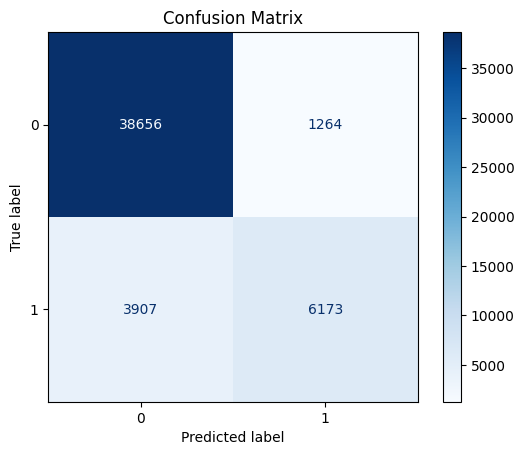


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     39920
           1       0.83      0.61      0.70     10080

    accuracy                           0.90     50000
   macro avg       0.87      0.79      0.82     50000
weighted avg       0.89      0.90      0.89     50000


Accuracy: 0.8966


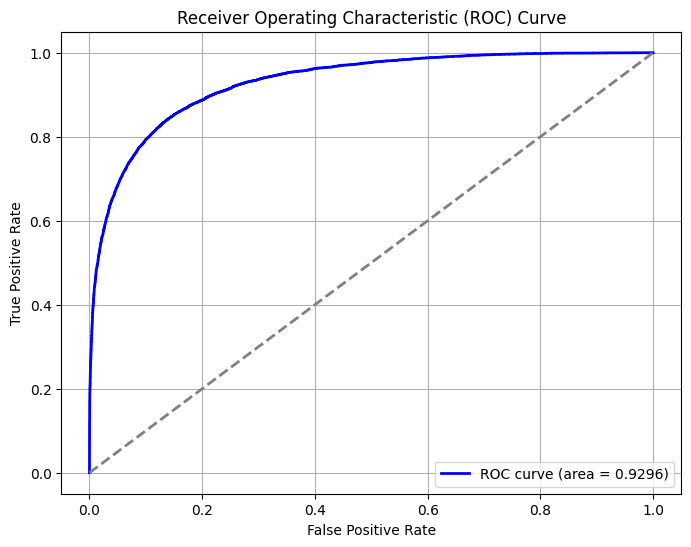

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacked_model.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


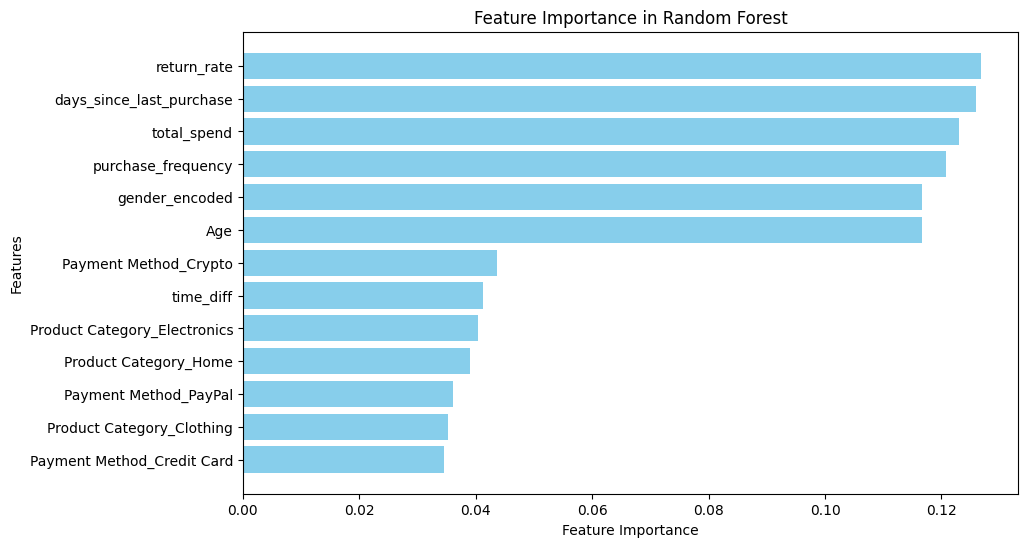

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': stacked_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()
